# **A Diffusion Model from Scratch in Pytorch**

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images.

### Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

In [1]:
import kagglehub

path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'stanford-cars-dataset' dataset.
Path to dataset files: /kaggle/input/stanford-cars-dataset


In [2]:
import os

print("Base path:", path)
for root, dirs, files in os.walk(path):
    print(root)
    # just show top few entries then break to avoid huge spam
    dirs[:] = dirs[:3]
    break


Base path: /kaggle/input/stanford-cars-dataset
/kaggle/input/stanford-cars-dataset


In [3]:
import glob
from PIL import Image
from torch.utils.data import Dataset

class StanfordCarsKaggle(Dataset):
  def __init__(self, root, transform=None):
    self.root = root
    self.transform = transform
    exts = ("*.jpg", "*.jpeg", "*.png")
    self.image_paths = []
    for ext in exts:
      self.image_paths.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    self.image_paths.sort()

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    img = Image.open(img_path).convert("RGB")
    if self.transform is not None:
      img = self.transform(img)
    label = 0
    return img, label

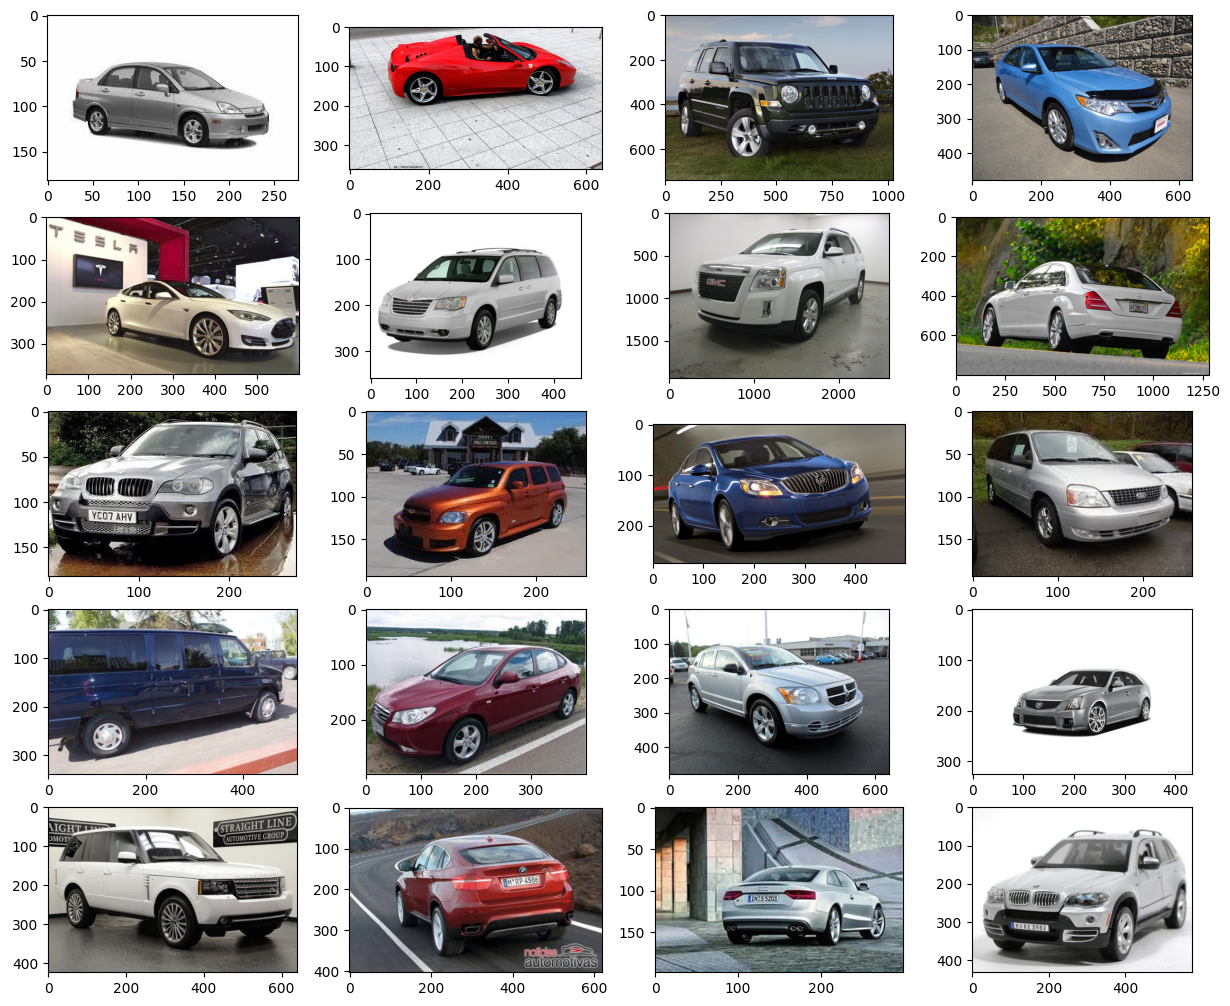

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(dataset, num_samples=20, cols=4):
  """ Plot some samples from the dataset """
  plt.figure(figsize=(15,15))
  for i, img in enumerate(dataset):
    if i == num_samples:
      break
    plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
    plt.imshow(img[0])
    # plt.axis('off')
  plt.show()

data = StanfordCarsKaggle(root=path)
show_images(data)

### Building the Diffusion Model

### Step 1: The forward process = Noise scheduler

In [5]:
from IPython.core.magics.script import time
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
  noise = torch.randn_like(x_0)
  sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
  # mean + variance
  return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
  + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

Let's test it on our dataset

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
  data_transforms = [
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),  # Scales data into [0, 1]
      transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
  ]
  data_transform = transforms.Compose(data_transforms)

  # Below version is depreciated
  # train = torchvision.datasets.StanfordCars(root=".", download=True,
  #                                           transform=data_transform)
  # test = torchvision.datasets.StanfordCars(root=".", download=True,
  #                                          transform=data_transform, split='test')
  # return torch.utils.data.ConcatDataset([train, test])

  # Use this new version rather
  dataset = StanfordCarsKaggle(root=path, transform=data_transform)
  return dataset

def show_tensor_image(image):
  reverse_trasforms = transforms.Compose([
      transforms.Lambda(lambda t: (t + 1) / 2),
      transforms.Lambda(lambda t: t.permute(1, 2, 0)),   # CHW to HWC
      transforms.Lambda(lambda t: t * 255.0),
      transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
      transforms.ToPILImage(),
  ])

  # Take the first image of batch
  if len(image.shape) == 4:
    image = image[0, :, :, :]
  plt.imshow(reverse_trasforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Simulate the forward diffusion

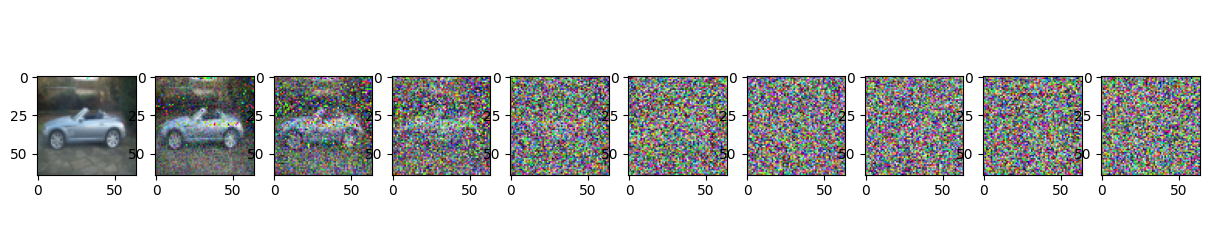

In [7]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15, 3))
plt.axis('off')
num_images = 10
stepsize = int(T/ num_images)

for idx in range(0, T, stepsize):
  t = torch.Tensor([idx]).type(torch.int64)
  plt.subplot(1, num_images, int(idx / stepsize) + 1)
  img, noise = forward_diffusion_sample(image, t)
  show_tensor_image(img)

## Step 2: The Backward process = U-Net

In [12]:
from torch import nn
import math

class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)
    if up:
      self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.bnorm1 = nn.BatchNorm2d(out_ch)
    self.bnorm2 = nn.BatchNorm2d(out_ch)
    self.relu = nn.ReLU()

  def forward(self, x, t):
    # First Conv
    h = self.bnorm1(self.relu(self.conv1(x)))
    # Time embedding
    time_emb = self.relu(self.time_mlp(t))
    # Extend last 2 dimensions
    time_emb = time_emb[(...,) + (None, ) * 2]
    # Add time channel
    h = h + time_emb
    # Second Conv
    h = self.bnorm2(self.relu(self.conv2(h)))
    # Down or Upsample
    return self.transform(h)

class SinusiodalPositionEmbeddings(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

class SimpleUnet(nn.Module):
  def __init__(self):
    super().__init__()
    image_channels = 3
    down_channels = (64, 128, 256, 512, 1024)
    up_channels = (1024, 512, 256, 128, 64)
    out_dim = 3
    time_emb_dim = 32

    # Time embedding
    self.time_mlp = nn.Sequential(
        SinusiodalPositionEmbeddings(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )

    # Initial projection
    self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

    # Downsample
    self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], \
                                      time_emb_dim) \
                                for i in range(len(down_channels) - 1)])
    # Upsample
    self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                    time_emb_dim, up=True) \
                              for i in range(len(up_channels) - 1)])
    self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

  def forward(self, x, timestep):
    #Embedded time
    t = self.time_mlp(timestep)
    # Initial conv
    x = self.conv0(x)
    # Unet
    residual_inputs = []
    for down in self.downs:
      x = down(x, t)
      residual_inputs.append(x)
    for up in self.ups:
      residual_x = residual_inputs.pop()
      # Add residual x as additional channels
      x = torch.cat((x, residual_x), dim=1)
      x = up(x, t)
    return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusiodalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Step 3: The loss

In [13]:
def get_loss(model, x_0, t):
  x_noisy, noise = forward_diffusion_sample(x_0, t, device)
  noise_pred = model(x_noisy, t)
  return F.l1_loss(noise, noise_pred)

## Sampling

In [16]:
@torch.no_grad()
def sample_timestep(x, t):
  betas_t = get_index_from_list(betas, t, x.shape)
  sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
      sqrt_one_minus_alphas_cumprod, t, x.shape
  )
  sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

  # Call model (current image - noise prediction)
  model_mean = sqrt_recip_alphas_t * (
      x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
  )
  posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

  if t == 0:
    # The t's are offset from the t's in the paper
    return model_mean
  else:
    noise = torch.randn_like(x)
    return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
  # Sample noise
  img_size = IMG_SIZE
  img = torch.randn((1, 3, img_size, img_size), device=device)
  plt.figure(figsize=(15, 3))
  plt.axis('off')
  num_images = 10
  stepsize = int(T / num_images)

  plot_index = 0
  for i in range(0, T)[::-1]:
    t = torch.full((1,), i, device=device, dtype=torch.long)
    img = sample_timestep(img, t)
    img = torch.clamp(img, -1.0, 1.0)
    if i % stepsize == 0:
      plot_index += 1
      plt.subplot(1, num_images, plot_index)
      show_tensor_image(img.detach().cpu())
  plt.show()

## Training

Using device: cuda
Epoch 0
Epoch 0 | step 000 Loss: 0.24006852507591248


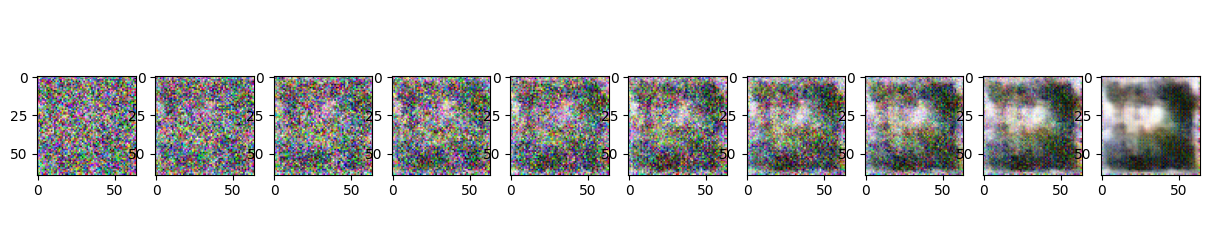

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 5 | step 000 Loss: 0.20551201701164246


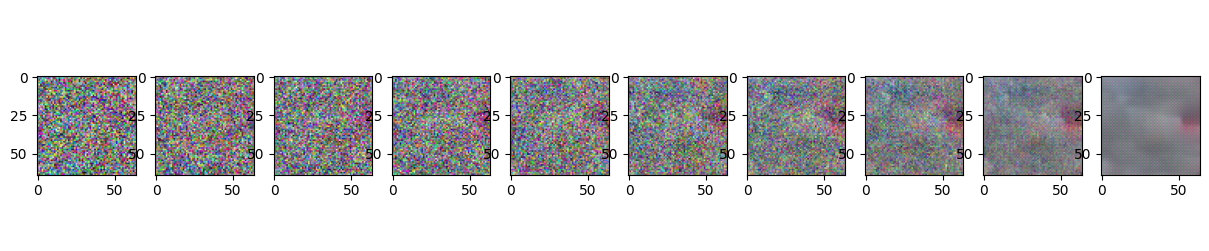

Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 10 | step 000 Loss: 0.15531079471111298


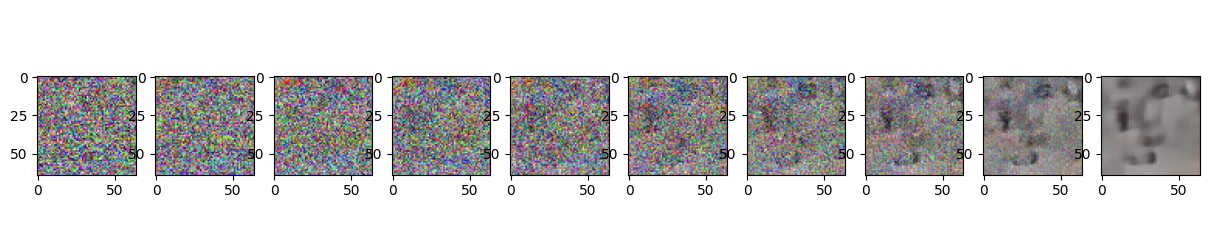

Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 15 | step 000 Loss: 0.15308985114097595


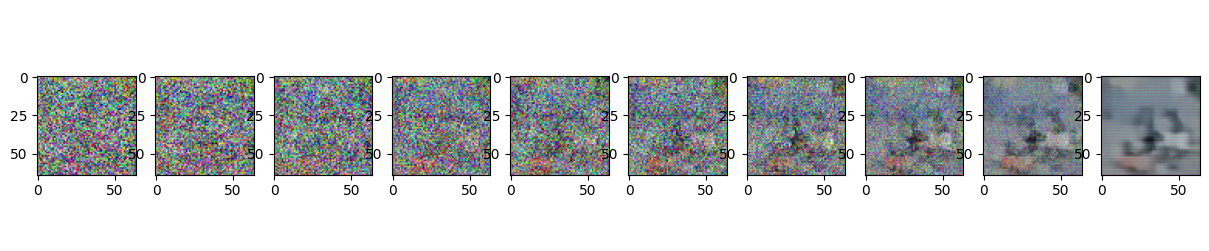

Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 20 | step 000 Loss: 0.14367619156837463


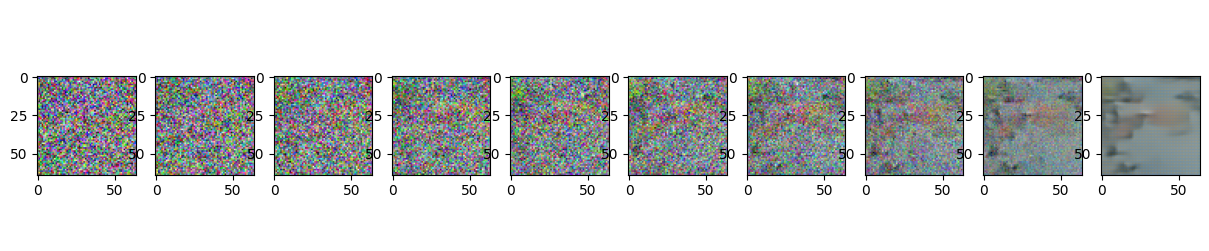

Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 25 | step 000 Loss: 0.14902125298976898


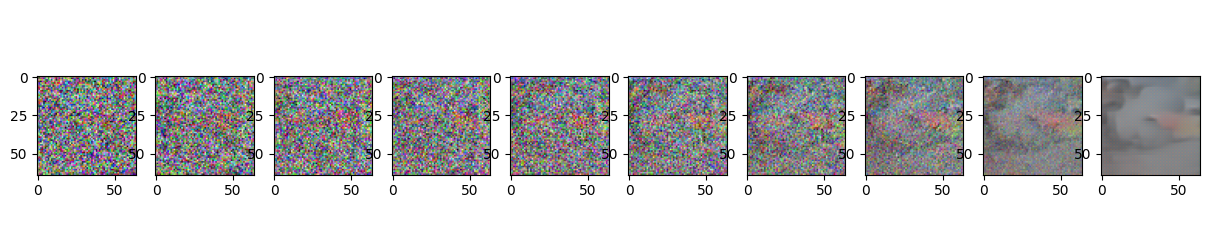

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more

for epoch in range(epochs):
  print(f"Epoch {epoch}")
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, batch[0], t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}")
      sample_plot_image()